In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from darts.models import ARIMA
from darts.models import TCNModel 
from darts import TimeSeries
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm
import pathlib
import os
import warnings
warnings.filterwarnings('ignore')


# Import Data

In [58]:
# Change to the project root directory
project_root = pathlib.Path("/Users/victormp/Desktop/ml/ml-project")
os.chdir(project_root)

# Now use relative path
data_path = pathlib.Path("data/DCOILWTICO.csv")
print(f"Loading from: {data_path.absolute()}")
print(f"File exists: {data_path.exists()}")

Loading from: /Users/victormp/Desktop/ml/ml-project/data/DCOILWTICO.csv
File exists: True


In [59]:
data = pd.read_csv(data_path)
data.rename(columns = {"observation_date" : "date", "DCOILWTICO" : "price"}, inplace  = True)
data["date"] = pd.to_datetime(data["date"])
data = data.set_index("date")
data["return"] = np.log(data["price"]) - np.log(data["price"].shift(1))
returns = data["return"].replace([np.inf, -np.inf], np.nan).dropna().astype("float32")



# Split Data
### Convert to TimeSeries object

In [60]:
split_point = int(len(returns) * 0.8)  # 80% train, 20% test
y_train = returns.iloc[:split_point]
y_test = returns.iloc[split_point:]

# Convert y_train["return"] and y_test["return"] to darts TimeSeries objects
train_series = TimeSeries.from_values(y_train)
test_series = TimeSeries.from_values(y_test)

# Train AR(1) Model
### Calculate residuals, preditions on training set, and the MSE

In [61]:
# Train model and calculate residuals, compute MSE
model = ARIMA(p=1, d=0, q=0)
model.fit(train_series)
residuals = model.residuals(train_series)
train_series_predict = model.predict(len(train_series))

# To avoid nan, only compute MSE on pairs where both are not nan
pred_vals = train_series_predict.values().flatten()
true_vals = train_series.values().flatten()

# Remove pairs where either is nan
mask = ~np.isnan(pred_vals) & ~np.isnan(true_vals)
mse = np.mean((pred_vals[mask] - true_vals[mask]) ** 2)


### Plot AR(1)

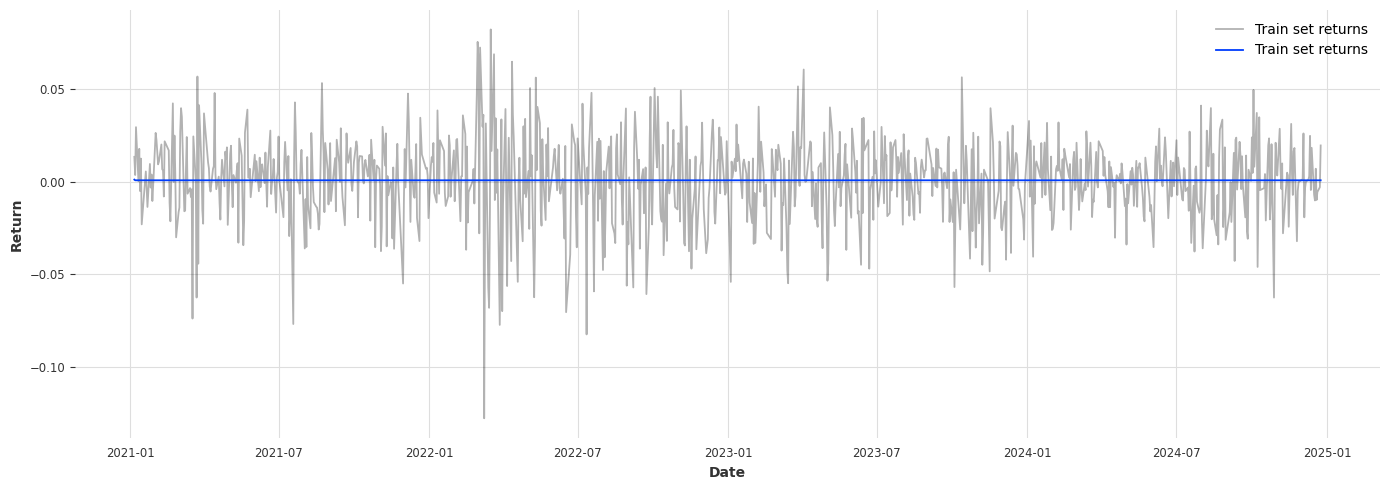

In [62]:
plt.figure(figsize=(14, 5))
sns.lineplot(x = y_train.index, y = y_train, alpha = 0.3, label = "Train set returns")
sns.lineplot(x = y_train.index, y = pred_vals, label = "Train set returns")
plt.xlabel("Date")
plt.ylabel("Return")
plt.legend()
plt.tight_layout()


# Train AR(1) residuals on TCN
### Predict residuals values used for training

In [63]:
residuals = residuals.astype("float32")

tcn_model = TCNModel(input_chunk_length = 16, output_chunk_length = 1, output_chunk_shift=0, kernel_size=2, num_filters=3, num_layers=3, dilation_base=4, weight_norm=True, dropout=0.2).fit(residuals)

residual_pred = tcn_model.historical_forecasts(residuals, retrain=False)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 126    | train
-------------------------------------------------------------
126       Trainable params
0         Non-trainable params
126       Total params
0.001     Total estimated model params size (MB)
41        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 29/29 [00:00<00:00, 117.55it/s, train_loss=0.000392]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 29/29 [00:00<00:00, 117.21it/s, train_loss=0.000392]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


### Plot AR(1) residuals with predicted TCN residuals

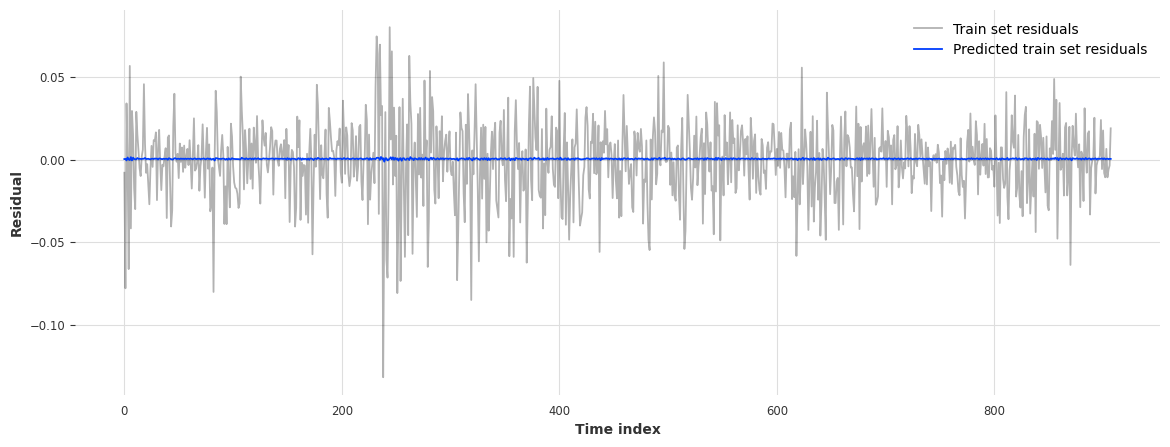

In [64]:
# Align residuals (predictions start after input_chunk_length=7)
pred_start_idx = 16  # input_chunk_length
real_residuals_aligned = residuals.values().flatten()[pred_start_idx:]
pred_residuals = residual_pred.values().flatten()

# Calculate MSE
mask = ~np.isnan(real_residuals_aligned) & ~np.isnan(pred_residuals)
mse_residuals = np.mean((real_residuals_aligned[mask] - pred_residuals[mask]) ** 2)

plt.figure(figsize=(14, 5))
time_idx = np.arange(len(real_residuals_aligned))
sns.lineplot(x=time_idx, y=real_residuals_aligned, alpha=0.3, label="Train set residuals")
sns.lineplot(x=time_idx, y=pred_residuals, label="Predicted train set residuals")

plt.xlabel("Time index")
plt.ylabel("Residual")
plt.show()

### Calculate MSE for for full prediction: AR(1) + TCN

In [65]:
data_loss = 46
pred_vals_adj = pred_vals[data_loss:]
total_pred_add = pred_vals_adj + pred_residuals     # Y_t = L_t + N_t
total_pred_mul = pred_vals_adj * pred_residuals     # Y_t = L_t * N_t

y_train_adj = y_train[data_loss:]

mse_total_pred_add = (1/len(y_train_adj)) * np.sum((y_train_adj - total_pred_add)**2)
mse_total_pred_mul = (1/len(y_train_adj)) * np.sum((y_train_adj - total_pred_mul)**2)

print(f"MSE AR(1): {mse}")
print(f"MSE AR(1) + TCN: {mse_total_pred_add}")
print(f"MSE AR(1) * TCN: {mse_total_pred_mul}")

MSE AR(1): 0.000523820428697776
MSE AR(1) + TCN: 0.0005345704832288805
MSE AR(1) * TCN: 0.0005347591989312588


# Creating Additive AR(1) + TCN (True Hybrid)

In [ ]:
class AR1_TCN_Model(nn.Module):
    def __init__(self, kernel_size=3, num_filters=64, num_layers=3, dilation_base=4):
        super().__init__()
        
        # AR(1) component - predicts next value from previous value
        self.ar_weight = nn.Parameter(torch.randn(1))
        self.ar_bias = nn.Parameter(torch.randn(1))
        
        # TCN for residuals
        layers = []
        for i in range(num_layers):
            dilation = dilation_base ** i
            padding = (kernel_size - 1) * dilation
            
            in_channels = 1 if i == 0 else num_filters
            
            conv = weight_norm(nn.Conv1d(
                in_channels=in_channels,
                out_channels=num_filters,
                kernel_size=kernel_size,
                dilation=dilation,
                padding=padding
            ))
            layers.append(conv)
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.1))
        
        # Output layer
        layers.append(nn.Conv1d(num_filters, 1, kernel_size=1))
        self.tcn = nn.Sequential(*layers)
    
    def forward(self, x):
        """
        x: (batch, sequence_length, 1) or (sequence_length,) or (batch, sequence_length)
        Returns: predictions for the sequence
        """
        # Handle different input shapes
        if x.dim() == 1:
            # (sequence_length,) -> (1, sequence_length, 1)
            x = x.unsqueeze(0).unsqueeze(2)
        elif x.dim() == 2:
            # (batch, sequence_length) -> (batch, sequence_length, 1)
            x = x.unsqueeze(2)
        
        batch_size, seq_len, _ = x.shape
        
        # Step 1: AR(1) predictions
        # For each timestep t, predict from timestep t-1
        ar_input = x[:, :-1, :]  # All but last timestep
        ar_predictions = self.ar_weight * ar_input + self.ar_bias  # (batch, seq_len-1, 1)
        
        # Step 2: Calculate residuals
        targets = x[:, 1:, :]  # All but first timestep
        residuals = targets - ar_predictions  # (batch, seq_len-1, 1)
        
        # Step 3: TCN on residuals
        residuals_transposed = residuals.transpose(1, 2)  # (batch, 1, seq_len-1)
        tcn_output = self.tcn(residuals_transposed)  # (batch, 1, output_len)
        tcn_predictions = tcn_output.transpose(1, 2)  # (batch, output_len, 1)
        
        # Step 4: Ensure TCN output matches AR predictions length
        # Crop or pad TCN output to match ar_predictions length
        residual_len = ar_predictions.shape[1]
        tcn_len = tcn_predictions.shape[1]
        
        if tcn_len > residual_len:
            # Crop TCN output from the end to match
            tcn_predictions = tcn_predictions[:, :residual_len, :]
        elif tcn_len < residual_len:
            # Pad TCN output with zeros at the beginning (causal padding)
            padding = residual_len - tcn_len
            tcn_predictions = torch.cat([
                torch.zeros(batch_size, padding, 1, device=tcn_predictions.device, dtype=tcn_predictions.dtype),
                tcn_predictions
            ], dim=1)
        
        # Step 5: Final prediction = AR(1) + TCN(residuals)
        final_predictions = ar_predictions + tcn_predictions
        
        return final_predictions, targets


# Training function
def train_model(y_train, num_epochs=100, lr=0.001):
    """
    y_train: can be numpy array or torch tensor of shape:
             - (sequence_length,)
             - (batch, sequence_length)
             - (batch, sequence_length, 1)
    """
    # Convert to torch tensor if needed
    if not isinstance(y_train, torch.Tensor):
        y_train = torch.FloatTensor(y_train)
    
    # Initialize model
    model = AR1_TCN_Model(kernel_size=3, num_filters=64, num_layers=3, dilation_base=4)
    
    # Training setup
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    # Training loop
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        
        # Forward pass
        predictions, targets = model(y_train)
        
        # Calculate loss: prediction vs original time series
        loss = criterion(predictions, targets)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')
    
    return model


### Calculating MSE for Additive AR(1) + TCN (True Hybrid)

In [67]:
# 1D array (single time series)
print("Example 1: 1D data")
model1_add = train_model(y_train.values)

# Make predictions
print("\n" + "="*50)
print("Making predictions...")
model1_add.eval()
with torch.no_grad():
    # Convert numpy array to torch tensor
    y_train_tensor = torch.FloatTensor(y_train.values)
    predictions_add, targets_add = model1_add(y_train_tensor)
    print(f"Prediction shape: {predictions_add.shape}")
    print(f"Target shape: {targets_add.shape}")

Example 1: 1D data
Epoch [10/100], Loss: 0.073895
Epoch [20/100], Loss: 0.032547
Epoch [30/100], Loss: 0.017561
Epoch [40/100], Loss: 0.014551
Epoch [50/100], Loss: 0.012294
Epoch [60/100], Loss: 0.012032
Epoch [70/100], Loss: 0.011995
Epoch [80/100], Loss: 0.010565
Epoch [90/100], Loss: 0.010191
Epoch [100/100], Loss: 0.008869

Making predictions...
Prediction shape: torch.Size([1, 953, 1])
Target shape: torch.Size([1, 953, 1])


# Creating Multiplicative AR(1) + TCN

In [68]:
class AR1_TCN_Model(nn.Module):
    def __init__(self, kernel_size=3, num_filters=64, num_layers=3, dilation_base=4):
        super().__init__()
        
        # AR(1) component - predicts next value from previous value
        self.ar_weight = nn.Parameter(torch.randn(1))
        self.ar_bias = nn.Parameter(torch.randn(1))
        
        # TCN for residuals
        layers = []
        for i in range(num_layers):
            dilation = dilation_base ** i
            padding = (kernel_size - 1) * dilation
            
            in_channels = 1 if i == 0 else num_filters
            
            conv = weight_norm(nn.Conv1d(
                in_channels=in_channels,
                out_channels=num_filters,
                kernel_size=kernel_size,
                dilation=dilation,
                padding=padding
            ))
            layers.append(conv)
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.1))
        
        # Output layer
        layers.append(nn.Conv1d(num_filters, 1, kernel_size=1))
        self.tcn = nn.Sequential(*layers)
    
    def forward(self, x):
        """
        x: (batch, sequence_length, 1) or (sequence_length,) or (batch, sequence_length)
        Returns: predictions for the sequence
        """
        # Handle different input shapes
        if x.dim() == 1:
            # (sequence_length,) -> (1, sequence_length, 1)
            x = x.unsqueeze(0).unsqueeze(2)
        elif x.dim() == 2:
            # (batch, sequence_length) -> (batch, sequence_length, 1)
            x = x.unsqueeze(2)
        
        batch_size, seq_len, _ = x.shape
        
        # Step 1: AR(1) predictions
        # For each timestep t, predict from timestep t-1
        ar_input = x[:, :-1, :]  # All but last timestep
        ar_predictions = self.ar_weight * ar_input + self.ar_bias  # (batch, seq_len-1, 1)
        
        # Step 2: Calculate residuals
        targets = x[:, 1:, :]  # All but first timestep
        residuals = targets - ar_predictions  # (batch, seq_len-1, 1)
        
        # Step 3: TCN on residuals
        residuals_transposed = residuals.transpose(1, 2)  # (batch, 1, seq_len-1)
        tcn_output = self.tcn(residuals_transposed)  # (batch, 1, output_len)
        tcn_predictions = tcn_output.transpose(1, 2)  # (batch, output_len, 1)
        
        # Step 4: Ensure TCN output matches AR predictions length
        # Crop or pad TCN output to match ar_predictions length
        residual_len = ar_predictions.shape[1]
        tcn_len = tcn_predictions.shape[1]
        
        if tcn_len > residual_len:
            # Crop TCN output from the end to match
            tcn_predictions = tcn_predictions[:, :residual_len, :]
        elif tcn_len < residual_len:
            # Pad TCN output with zeros at the beginning (causal padding)
            padding = residual_len - tcn_len
            tcn_predictions = torch.cat([
                torch.zeros(batch_size, padding, 1, device=tcn_predictions.device, dtype=tcn_predictions.dtype),
                tcn_predictions
            ], dim=1)
        
        # Step 5: Final prediction = AR(1) + TCN(residuals)
        final_predictions = ar_predictions * tcn_predictions
        
        return final_predictions, targets


# Training function
def train_model(y_train, num_epochs=100, lr=0.001):
    """
    y_train: can be numpy array or torch tensor of shape:
             - (sequence_length,)
             - (batch, sequence_length)
             - (batch, sequence_length, 1)
    """
    # Convert to torch tensor if needed
    if not isinstance(y_train, torch.Tensor):
        y_train = torch.FloatTensor(y_train)
    
    # Initialize model
    model = AR1_TCN_Model(kernel_size=3, num_filters=64, num_layers=3, dilation_base=4)
    
    # Training setup
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    # Training loop
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        
        # Forward pass
        predictions, targets = model(y_train)
        
        # Calculate loss: prediction vs original time series
        loss = criterion(predictions, targets)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')
    
    return model


### Calculating MSE for Multiplicative AR(1) + TCN (True Hybrid)

In [69]:
# 1D array (single time series)
print("Example 1: 1D data")
model1_mul = train_model(y_train.values)

# Make predictions
print("\n" + "="*50)
print("Making predictions...")
model1_mul.eval()
with torch.no_grad():
    # Convert numpy array to torch tensor
    y_train_tensor = torch.FloatTensor(y_train.values)
    predictions_mul, targets_mul = model1_mul(y_train_tensor)
    print(f"Prediction shape: {predictions_mul.shape}")
    print(f"Target shape: {targets_mul.shape}")

Example 1: 1D data
Epoch [10/100], Loss: 0.000914
Epoch [20/100], Loss: 0.000882
Epoch [30/100], Loss: 0.000756
Epoch [40/100], Loss: 0.000714
Epoch [50/100], Loss: 0.000635
Epoch [60/100], Loss: 0.000658
Epoch [70/100], Loss: 0.000643
Epoch [80/100], Loss: 0.000576
Epoch [90/100], Loss: 0.000599
Epoch [100/100], Loss: 0.000587

Making predictions...
Prediction shape: torch.Size([1, 953, 1])
Target shape: torch.Size([1, 953, 1])


In [70]:
y_train_adj = y_train[1:]
predictions_add_np = predictions_add.numpy().flatten()
predictions_mul_np = predictions_mul.numpy().flatten()
mse_true_hybrid_add = (1/len(y_train_adj))*np.sum((y_train_adj - predictions_add_np)**2)
mse_true_hybrid_mul = (1/len(y_train_adj))*np.sum((y_train_adj - predictions_mul_np)**2)

print(f"MSE AR(1): {mse}")
print(f"MSE AR(1) + TCN: {mse_total_pred_add}")
print(f"MSE AR(1) * TCN: {mse_total_pred_mul}")
print(f"MSE AR(1) + TCN (true hybrid): {mse_true_hybrid_add}")
print(f"MSE AR(1) * TCN (true hybrid): {mse_true_hybrid_mul}")

MSE AR(1): 0.000523820428697776
MSE AR(1) + TCN: 0.0005345704832288805
MSE AR(1) * TCN: 0.0005347591989312588
MSE AR(1) + TCN (true hybrid): 0.004329264101426724
MSE AR(1) * TCN (true hybrid): 0.0005040198783434201
